In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from autograd import multigrad
import autograd.numpy as np
%matplotlib inline

In [2]:
import pickle

In [3]:
import sys
sys.path.append('../code/')

from common import APPLIANCES_ORDER, contri
from plot_functions import latexify, format_axes

In [291]:
cases = {
    1: {'HA': 'Ma, Nb -> MNab', 'HAT': 'MNab, Oab -> MNO'},
    2: {'HA': 'Ma, Nab -> MNb', 'HAT': 'MNb, Ob -> MNO'},
    3: {'HA': 'Mab, Na -> MNb', 'HAT': 'MNb, Ob -> MNO'},
    4: {'HA': 'Ma, Na -> MNa', 'HAT': 'MNa, Oa -> MNO'}
}

def calculate_l21_norm(X):
    """
    This function calculates the l21 norm of a matrix X, i.e., \sum ||X[i,:]||_2
    Input:
    -----
    X: {numpy array}, shape (n_samples, n_features)
    Output:
    ------
    l21_norm: {float}
    """
    return (np.sqrt(np.multiply(X, X).sum(1))).sum()

def cost_l21(H, A, T,  E_np_masked, lam, case):
   
    HAT = np.einsum('Hh, Ahs, Ts ->HAT', H, A, T)
    mask = ~np.isnan(E_np_masked)
    error_1 = (HAT - E_np_masked)[mask].flatten()
    
    #error_2=0.0
    error_2 = calculate_l21_norm(H)

    return np.sqrt((error_1 ** 2).mean()) + lam * error_2


def cost_l1(H, A, T,  E_np_masked, lam, case):
   
    HAT = np.einsum('Hh, Ahs, Ts ->HAT', H, A, T)
    mask = ~np.isnan(E_np_masked)
    error_1 = (HAT - E_np_masked)[mask].flatten()
    
    #error_2=0.0
    error_2 = np.sum(H)

    return np.sqrt((error_1 ** 2).mean()) + lam * error_2

def learn_HAT_adagrad(case, tensor, num_home_factors, num_season_factors, num_iter=2000, lr=0.01, dis=False,
                            lam=1, random_seed=0, eps=1e-8, A_known = None, T_known = None, cost=cost_l1):
    np.random.seed(random_seed)
    args_num=[0,1,2]
    
    mg = multigrad(cost, argnums=args_num)

    params = {}
    params['M'], params['N'], params['O'] = tensor.shape
    params['a'] = num_home_factors
    params['b'] = num_season_factors
    H_dim_chars = list(cases[case]['HA'].split(",")[0].strip())
    H_dim = tuple(params[x] for x in H_dim_chars)
    A_dim_chars = list(cases[case]['HA'].split(",")[1].split("-")[0].strip())
    A_dim = tuple(params[x] for x in A_dim_chars)
    T_dim_chars = list(cases[case]['HAT'].split(",")[1].split("-")[0].strip())
    T_dim = tuple(params[x] for x in T_dim_chars)

    H = np.random.rand(*H_dim)
    A = np.random.rand(*A_dim)
    T = np.random.rand(*T_dim)

    if A_known is not None:
        A = set_known(A, A_known)
    sum_square_gradients_A = np.zeros_like(A)
    sum_square_gradients_H = np.zeros_like(H)
    sum_square_gradients_T = np.zeros_like(T)
    
    # GD procedure
    for i in range(num_iter):
        del_h, del_a, del_t = mg(H, A, T, tensor, lam, case)
        
        sum_square_gradients_A += eps + np.square(del_a)
        lr_a = np.divide(lr, np.sqrt(sum_square_gradients_A))
        A -= lr_a * del_a
        
        sum_square_gradients_H += eps + np.square(del_h)
        sum_square_gradients_T += eps + np.square(del_t)

        lr_h = np.divide(lr, np.sqrt(sum_square_gradients_H))
        lr_t = np.divide(lr, np.sqrt(sum_square_gradients_T))

        H -= lr_h * del_h
        T -= lr_t * del_t

        if T_known is not None:
            T = set_known(T, T_known)
        if A_known is not None:
            A = set_known(A, A_known)

        # Projection to non-negative space
        H[H < 0] = 1e-8
        A[A < 0] = 1e-8
        T[T < 0] = 1e-8

        


        if i % 100 == 0:
            if dis:
                print(cost(H, A, T, tensor, lam, case))
    
    return H, A, T

In [5]:
from common import create_region_df_dfc_static, get_tensor
source='Austin'
year=2014
start, stop = 1, 13
source_df, source_dfc, source_tensor, source_static = create_region_df_dfc_static(source, year, start, stop)


In [6]:
tensor = get_tensor(source_df, start, stop)

In [7]:
tensor.shape

(533, 7, 12)

In [296]:
from sklearn.model_selection import KFold

In [382]:
kf = KFold(n_splits=5)
all_pred = {}
for lam in [0, 1e-3, 1e-2, 1e-1, 1]:
    print "*"*20
    print lam
    print "*"*20
    out = np.zeros_like(tensor)
    out[:] = np.nan
    lam = 0.05
    for train, test in kf.split(source_df):
        train_ix = source_df.index[train]
        test_ix = source_df.index[test]
        tensor_copy = tensor.copy()
        tensor_copy[test, 1:, :] = np.nan

        H, A, T = learn_HAT_adagrad(case=2, tensor=tensor_copy, num_home_factors=10, num_season_factors=2,
                                                    lam=lam, dis=True, lr=1, num_iter=300,
                                                   cost=cost_l21)
        pred_tensor = np.einsum('Hh, Ahs, Ts ->HAT', H, A, T)
        out[test, :, :] = pred_tensor[test]
    all_pred[lam] = out

********************
0
********************
541.223829826
167.73462422
144.999865161
542.169768207
167.731214243
144.718602995
539.148928764
164.513245802
143.162196732
539.755938912
164.201042441
140.365244254
540.269304267
165.06434057
142.670013056
********************
0.001
********************
541.223829826
167.73462422
144.999865161
542.169768207
167.731214243
144.718602995
539.148928764
164.513245802
143.162196732
539.755938912
164.201042441
140.365244254
540.269304267
165.06434057
142.670013056
********************
0.01
********************
541.223829826
167.73462422
144.999865161
542.169768207
167.731214243
144.718602995
539.148928764
164.513245802
143.162196732
539.755938912
164.201042441
140.365244254
540.269304267
165.06434057
142.670013056
********************
0.1
********************
541.223829826
167.73462422
144.999865161
542.169768207
167.731214243
144.718602995
539.148928764
164.513245802
143.162196732
539.755938912
164.201042441
140.365244254
540.269304267
165.064340

In [381]:
from common import compute_rmse_fraction
appliance = "hvac"

pred_appliance = pd.DataFrame(out[:, APPLIANCES_ORDER.index(appliance), :], index=source_df.index)
if appliance=="hvac":
    pred_appliance = pred_appliance[range(4, 10)]
compute_rmse_fraction(appliance=appliance,pred_df=pred_appliance, year=2014)[2]

15.285399393019834

In [372]:
pred_appliance.isnull().sum().sum()

0L

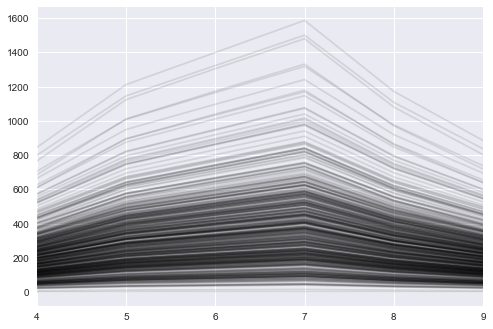

In [378]:
pred_appliance.T.plot(legend=False, color='k',alpha=0.1)

In [294]:
H[H<1e-3] = 0
np.count_nonzero(H)

4891

In [295]:
H.size

5330

In [284]:
HF = pd.DataFrame(H)

In [285]:
import seaborn as sns

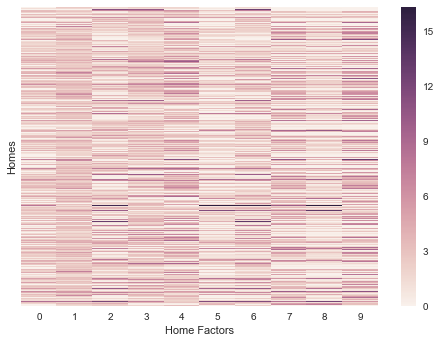

In [286]:
sns.heatmap(HF, yticklabels=False)
plt.xlabel("Home Factors")
plt.ylabel("Homes")

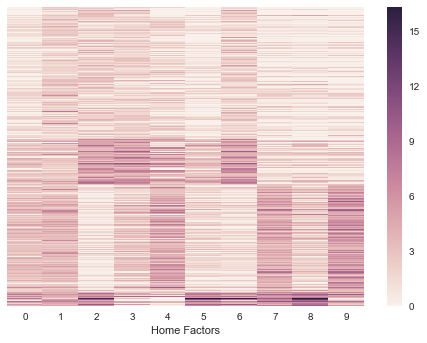

In [287]:
np.random.seed(0)
from sklearn.cluster import KMeans
km = KMeans(n_clusters=4)
km.fit(HF)
sns.heatmap(pd.concat([HF[km.labels_==x] for x in range(4)]), yticklabels=False)
plt.xlabel("Home Factors")

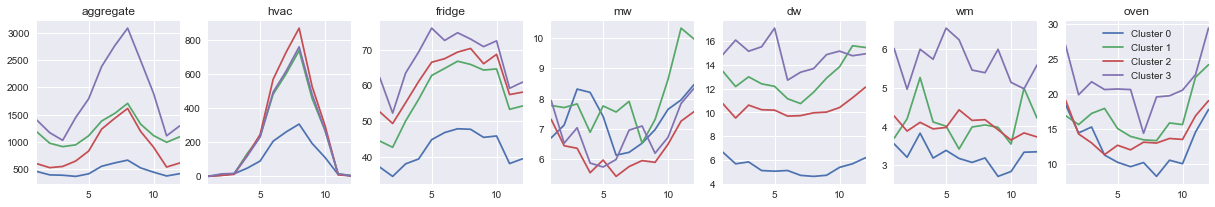

In [290]:
fig, ax = plt.subplots(nrows=1, ncols=7, figsize=(21, 3))
for i, appliance in enumerate(APPLIANCES_ORDER):
    for cluster_num in range(4):
        d = source_df.loc[source_df.index[km.labels_==cluster_num]][['%s_%d' %(appliance, month) for month in range(1, 13)]].mean()
        d.index = range(1, 13)
        d.plot(ax=ax[i], title=appliance, label="Cluster %d" %cluster_num)
plt.legend()

In [263]:
source_df.index

Int64Index([  22,   26,   48,   59,   68,   77,   86,   93,   94,  101,
            ...
            9933, 9935, 9936, 9937, 9938, 9939, 9942, 9971, 9981, 9982],
           dtype='int64', length=533)

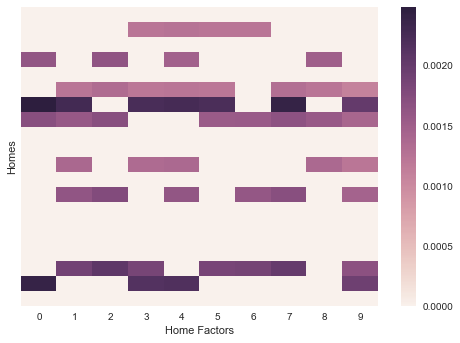

In [223]:
sns.heatmap(HF.head(20), yticklabels=False)
plt.xlabel("Home Factors")
plt.ylabel("Homes")